# Классификация твитов
### Иван Людвиг Терешко, Б03-901

In [15]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import gensim
from gensim.models import Word2Vec
import nltk
import numpy as np
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV

## Preproccessing

In [2]:
df = pd.read_csv('Tweets.csv')

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.fillna(0)
df['airline_sentiment'] = df['airline_sentiment'].map({'positive': 1, 'neutral': 0,'negative': -1})
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,0,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,0,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,-1,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,-1,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
sentiments = ['negative', 'neutral', 'positive']
df['text'] = df['text'].apply(lambda x: x.lower())
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
0,@virginamerica what @dhepburn said.,0
1,@virginamerica plus you've added commercials t...,1
2,@virginamerica i didn't today... must mean i n...,0
3,@virginamerica it's really aggressive to blast...,-1
4,@virginamerica and it's a really big bad thing...,-1


## Использование word2vec

Токенизация текста с выкидыванием стоп-слов

In [7]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            if word in stopwords.words('english'):
                continue
            tokens.append(word)
    return tokens

Простое усреднение текста

In [8]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)
    if not mean:
        return np.zeros(300,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [9]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(sentiments))
    target_names = sentiments
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [10]:
wv = gensim.models.KeyedVectors.load_word2vec_format("drive/MyDrive/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [11]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

Токенизируем наши данные, получаем массивы, содержащие основные слова (токены)

In [12]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

Считаем средний вектор к нашим данным

In [13]:
X_train_word_average = word_averaging_list(wv, train_tokenized)
X_test_word_average = word_averaging_list(wv, test_tokenized)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  import sys
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Обучаем линейную регрессию с сеткой

In [16]:
logreg = LogisticRegression()

grid_searcher = GridSearchCV(
    estimator=LogisticRegression(max_iter=500),
    param_grid={
        'C': [2**(x/10.0) for x in range(-50, 50, 10)]
    },
    scoring='accuracy').fit(X_train_word_average, train_data['airline_sentiment'])

best_model = grid_searcher.best_estimator_
best_params = grid_searcher.best_params_

best_params

{'C': 4.0}

В результате получаем

accuracy 0.7937158469945356
confusion matrix
 [[2581  170   63]
 [ 373  442   69]
 [ 133   98  463]]
(row=expected, col=predicted)


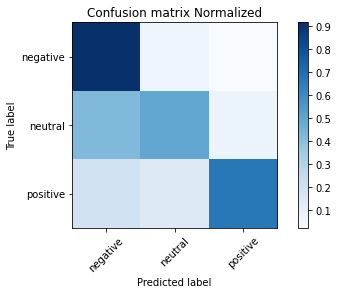

In [17]:
predicted = best_model.predict(X_test_word_average)
evaluate_prediction(predicted, test_data.airline_sentiment)

### Средневзвешенное слов с помощью TF-IDF

Функция для усреднения текста с учётом весов

In [19]:
def weighted_word_averaging(wv, words):
    all_words, mean = set(), []
    weight_sum = 0
    weights = []
    for word in words:
        weight = 1
        if word in weighted_words:
            weight = weighted_words[word]
        if isinstance(word, np.ndarray):
            mean.append(word*word_weight)
            weights.append(weight)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)
            weights.append(weight)

    if not mean:
        return np.zeros(300,)

    word_array = np.array(mean) / sum(weights)
    mean = gensim.matutils.unitvec(np.average(word_array, weights=weights, axis=0)).astype(np.float32)
    return mean

def weighted_word_averaging_list(wv, text_list):
    return np.vstack([weighted_word_averaging(wv, review) for review in text_list])

Веса берем в соотвествии с TF-IDF

In [20]:
tfidf = TfidfVectorizer()
matrix_count = tfidf.fit_transform(df['text'])
tfidf_words = tfidf.get_feature_names()
weighted_words = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

Далее аналогично обучаем модель

In [21]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

In [22]:
X_train_word_average = weighted_word_averaging_list(wv, train_tokenized)
X_test_word_average = weighted_word_averaging_list(wv, test_tokenized)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [23]:
logreg = LogisticRegression()

grid_searcher = GridSearchCV(
    estimator=LogisticRegression(max_iter=500),
    param_grid={
        'C': [2**(x/10.0) for x in range(-50, 50, 10)]
    },
    scoring='accuracy').fit(X_train_word_average, train_data['airline_sentiment'])

best_model = grid_searcher.best_estimator_
best_params = grid_searcher.best_params_

best_params

{'C': 8.0}

accuracy 0.7793715846994536
confusion matrix
 [[2550  184   80]
 [ 393  417   74]
 [ 134  104  456]]
(row=expected, col=predicted)


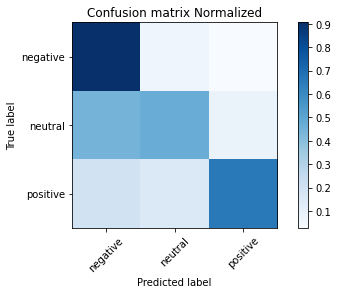

In [24]:
predicted = best_model.predict(X_test_word_average)
evaluate_prediction(predicted, test_data.airline_sentiment)

В итоге мы получили результат 0.779, что хуже, чем используя обычное усреднее (0.794).

Применяя word2vec мы получили accuracy 0.794. Этот результат немного хуже, чем полученный с использованием BagOfWords (0.801).